In [ ]:
import pickle
import tensorflow as tf
import numpy as np

from keras.layers import Lambda,Reshape,concatenate,Input, Embedding, LSTM
from keras.layers import Dense,Dropout, Activation ,Flatten ,RepeatVector, Bidirectional,GlobalAveragePooling1D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam,SGD
from keras.activations import softmax
from keras import regularizers

from keras import backend as K, regularizers, constraints, initializers
from keras.engine.topology import Layer

from keras.layers import merge
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.models import Sequential

from keras.callbacks import EarlyStopping


from Attention import Attention

from keras.layers import Concatenate,Dot
from keras.layers import Permute, merge

# FOR ATAE
from AttentionwithContext import AttentionWithContext
from Final import FinalSentenceRepresentation

from final2 import Final2

from keras.models import model_from_json



In [4]:
#Early stopping by F1
import keras
class EarlyStopByF1(keras.callbacks.Callback):
    def __init__(self, value = 0, verbose = 0):
        super(keras.callbacks.Callback, self).__init__()
        self.value = value
        self.verbose = verbose


    def on_epoch_end(self, epoch, logs={}):
         predict = np.asarray(self.model.predict(self.validation_data[0]))
         target = self.validation_data[1]
         score = f1_score(target, prediction)
         if score > self.value:
            if self.verbose >0:
                print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True


In [2]:
a=pickle.load(open("D:/PythonCodes/Sentiment-Analysis/Data/all_data.dat","rb"))
b=pickle.load(open("D:/PythonCodes/Sentiment-Analysis/Data/all_data23.dat","rb"))



In [3]:
b.keys()

dict_keys(['test_raw', 'embedding_matrix_sentiment', 'input_aspect', 'sentiment_Y', 'validation_Y', 'text_raw', 'h_sentence', 'train_sentiment', 'aspect_level2', 'h_aspect_encoding', 'h_target', 'sentiment_X', 'validation_X', 'p_aspect', 'h_sentiment', 'p_target', 'h_aspect', 'p_aspect_encoding', 'p_sentiment', 'vocab_size', 'sentence', 'p_sentence', 'lable_encoding', 'target', 'aspect', 'sentiment_Tar'])

In [4]:
embedding_matrix=b['embedding_matrix_sentiment']
TARGET=b['sentiment_Tar']
SENTENCE=b['sentiment_X']
SENTIMENT=b['sentiment_Y']
vocab_size=b['vocab_size']

In [7]:
TARGET=np.tile(TARGET,11)


In [5]:
input_context=a['aug_sentence']
#input_target=a['target']

label_encoding=a['lable_encoding']

embedding_matrix=a['embedding_matrix']

sentiment= a['train_sentiment']
aspect=a['aug_aspect']

text_raw= a['text_raw']
test_raw=a['test_raw']

In [6]:
(vocab_size)

5655

In [7]:
h_sentence=a['h_sentence']
h_aspect_encoding=a['h_aspect_encoding']
h_sentiment= a['h_sentiment']


p_sentence=a['p_sentence']
p_aspect_encoding=a['p_aspect_encoding']
p_sentiment= a['p_sentiment']

In [8]:
p_aspect_encoding

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:


y=[]
for i in h_aspect_encoding:
    y.append(list(i))
for j in p_aspect_encoding:
    y.append(list(j)) 
print(len(y))
y=np.array(y)


192


In [12]:
np.array(y)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
validation_X=a['validation_X']
validation_Y=np.array(a['validation_Y'])


In [15]:
#input_aspect=a['input_aspect']
vocab_size=a['vocab_size']
#print(len(input_aspect[0]))

In [ ]:
input_aspect=np.tile(input_aspect,11)
print(len(input_aspect[0]))

In [ ]:
def sk_mse_1(y_true,y_pred):
     return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
def sk_mse(y_true,y_pred):
     return np.mean(np.square(y_pred - y_true), axis=-1)

In [ ]:
max_length=11

### Inputs for  models

In [13]:
input_target[0]

NameError: name 'input_target' is not defined

In [14]:
trainX= [input_context, input_target]
trainY= sentiment

NameError: name 'input_target' is not defined

In [16]:
vocab_size=a['vocab_size']

In [16]:
def r2_error(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Sentiment Models

# AT MODEL

In [17]:
def Model_AT(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag, em_dim):
    
    
    input_context= Input(shape=(max_length,),name='Context')
    input_target = Input(shape=(max_length,),name='Target')
  
   
    #print(input_target.shape)
    #print(input_context.shape)
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
    v_target = embedding(input_target)
    
    
    #print(context.shape)
    print("Target" ,v_target.shape)

    
    #concat = concatenate(inputs =[target,context])
    #print(concat.shape)
    #inputs = Dropout(dropout)(concat)
    #print(inputs.shape)   
    
    
    H = LSTM (lstm_out, recurrent_dropout=dropout,return_sequences=True)(context)
    H = LSTM (lstm_out, recurrent_dropout=dropout,return_sequences=True)(H)
    H_all, H_last , _ = LSTM (lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="AT")(H)

    #print(H_all.shape , "H_all before reduction")
    H_all_1 =GlobalAveragePooling1D()(H_all)
    #print(H_all.shape , "H_all after reduction")

    #Target = GlobalAveragePooling1D()(v_target)
    #print(Target.shape , "Target after reduction")
    
    concat = concatenate(inputs =[v_target,H_all])
    print("Concat",concat.shape)
    
    r=AttentionWithContext(name='Attention')([H_all,concat])
    
    #print("h_ n ", H_last.shape)
    

    out=FinalSentenceRepresentation(name='Final')([r , H_all_1])
    
    #out=Dense(int((2*lstm_out+1)/2),activation='relu')(out)
            
    out= Dense(1, activation='sigmoid',  kernel_regularizer=regularizers.l2(0.01))(out)

    #print(out.shape)
    
    AT_model= Model(inputs=[input_context,input_target],outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    AT_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = [sk_mse_1])
    
    
    print(AT_model.summary())
    
    return AT_model

In [82]:
AT_model = Model_AT(learning_rate=0.00069,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

Target (?, 11, 300)
Concat (?, 11, 600)
M1 (?, 11, 600)
M (?, 11, 1)
alpha (?, 11, 1)
r (?, 300)
H_last (?, 300)
m1  (?, 300)
m2.shape (?, 300)
(?, 300) h_final
OUT (?, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 11, 300)      997200      Context[0][0]                    
                                                                 Target[0][0]                     
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 11, 300)      721200      embedding_4[0][0]                
____________________________________

In [22]:
AT_model = AT_model.fit(x=trainX,y=trainY, epochs=50,batch_size=64,validation_data=(testX,testY))



Train on 1173 samples, validate on 192 samples
Epoch 1/50
1173/1173 [==============================] - 8s 7ms/step - loss: 0.6996 - sk_mse: 0.0409 - val_loss: 0.7112 - val_sk_mse: 0.0483
Epoch 2/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.6912 - sk_mse: 0.0369 - val_loss: 0.7094 - val_sk_mse: 0.0474
Epoch 3/50
1173/1173 [==============================] - 5s 5ms/step - loss: 0.6824 - sk_mse: 0.0326 - val_loss: 0.7064 - val_sk_mse: 0.0461
Epoch 4/50
1173/1173 [==============================] - 5s 5ms/step - loss: 0.6774 - sk_mse: 0.0303 - val_loss: 0.7036 - val_sk_mse: 0.0447
Epoch 5/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.6728 - sk_mse: 0.0282 - val_loss: 0.7023 - val_sk_mse: 0.0443
Epoch 6/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.6683 - sk_mse: 0.0262 - val_loss: 0.7059 - val_sk_mse: 0.0460
Epoch 7/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.6678 - sk_mse: 0.0260 - val_loss: 0

# Adding Attention to our model 

In [17]:
def define_model_1(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag,em_dim):
     
    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
        
    a = Bidirectional(LSTM(300, return_sequences=True,recurrent_dropout=dropout))(context)
    
    print(a.shape)

    alpha = Attention()(a)
    
    x=Dense(300,activation='relu')(alpha)
        
    out=Dense(1,activation='linear')(x)
    
    model= Model(inputs=input_context ,outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    model.compile(loss = 'mse', optimizer=optimizer,metrics = ['mae','mse', r2_error, 'cosine'])
    
    
    print(model.summary())
    
    return model

In [18]:
Our_model = define_model_1(learning_rate=0.0001,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

(?, ?, 600)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Context (InputLayer)         (None, 11)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 11, 300)           997200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 11, 600)           1442400   
_________________________________________________________________
attention_1 (Attention)      (None, 600)               611       
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 2,620,812
Trainable params: 1,623,612
Non-trainable params: 997,200
________________________________________________

In [19]:
import tensorflow as tf
class EarlyStopByMSE(keras.callbacks.Callback):
    def __init__(self, verbose = 0,mode='min',patience=5,monitor='val_loss',baseline=None):
        super(keras.callbacks.Callback, self).__init__()
        self.verbose = verbose
        self.patience = 5
        self.baseline = baseline
        self.monitor=monitor

        if mode == 'min':
            self.monitor_op = np.less
    
    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.wait = 0
        if self.baseline is not None:
            self.best = self.baseline
        else:
            self.best = -np.Inf if self.monitor_op == np.less else np.Inf

    def on_epoch_end(self, epoch,logs=None):
        
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        target =np.asarray(self.validation_data[1])
        #print(target)
        current = sk_mse(target, predict)
        #print(current)
        
        if np.mean(current) < np.mean(self.best):
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                
        
        

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))



In [20]:
#earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=5)
Our_model.fit(x=input_context,y=trainY, epochs=100,batch_size=8)

Epoch 1/100
1173/1173 [==============================] - 24s 20ms/step - loss: 0.0859 - mean_absolute_error: 0.2363 - mean_squared_error: 0.0859 - r2_error: -2.4101 - cosine_proximity: -0.9761
Epoch 2/100
1173/1173 [==============================] - 27s 23ms/step - loss: 0.0450 - mean_absolute_error: 0.1781 - mean_squared_error: 0.0450 - r2_error: -0.4952 - cosine_proximity: -1.0000
Epoch 3/100
1173/1173 [==============================] - 20s 17ms/step - loss: 0.0364 - mean_absolute_error: 0.1591 - mean_squared_error: 0.0364 - r2_error: -0.2755 - cosine_proximity: -1.0000
Epoch 4/100
1173/1173 [==============================] - 21s 18ms/step - loss: 0.0318 - mean_absolute_error: 0.1475 - mean_squared_error: 0.0318 - r2_error: -0.0351 - cosine_proximity: -1.0000
Epoch 5/100
1173/1173 [==============================] - 21s 18ms/step - loss: 0.0293 - mean_absolute_error: 0.1393 - mean_squared_error: 0.0293 - r2_error: 0.0785 - cosine_proximity: -1.0000 6s - loss: 0.0295 - mean_absolute_er

KeyboardInterrupt: 

In [ ]:
model=Our_model.to_json()
with open("Our_model.json", "w") as json_file:
    json_file.write(model)
# serialize weights to HDF5
Our_model.save_weights("Our_model.h5")
print("Saved model to disk")

In [35]:
from scipy.interpolate import interp1d

def rescale(series,old_range,new_range):
    m = interp1d(old_range,new_range)
    return [float(m(x)) for x in series]

In [36]:

pred_sentiment =Our_model.predict(p_sentence)

pred_sentiment = rescale(pred_sentiment,[0,1],[-1,1])

outputs= sk_mse(p_sentiment,pred_sentiment)

print("Post MSE:", outputs)

Post MSE: 0.14276643428105218


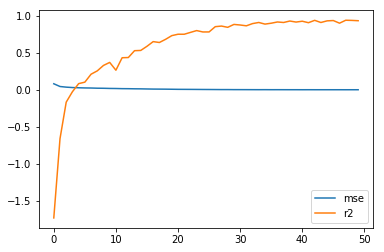

In [37]:
from matplotlib import pyplot
import pylab 

pyplot.plot(Our_model.history['mean_squared_error'],label='mse')
#pyplot.plot(Our_model.history['mean_absolute_error'],label='mae')
pyplot.plot(Our_model.history['r2_error'],label='r2')
#pyplot.plot(Our_model.history['cosine_proximity'],label='cosine')
pylab.legend(loc='lower right')


#legend((line1, line2, line3,line4), ('mse', 'mae', 'r2','cosine'))


# AT-AE MODEL


In [ ]:
def Model_ATAE(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag, em_dim):
    
    
    input_context= Input(shape=(max_length,),name='Context')
    input_target = Input(shape=(max_length,),name='Target')
  
   
    #print(input_target.shape)
    #print(input_context.shape)
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
    v_target = embedding(input_target)
    
    #print(context.shape)
    print("Target" ,v_target.shape)

    
    concat = concatenate(inputs =[v_target,context])
    print(concat.shape)
    inputs = Dropout(dropout)(concat)
    print(inputs.shape)   
    
    H = LSTM (lstm_out, recurrent_dropout=dropout,return_sequences=True)(inputs)
    H = LSTM (lstm_out, recurrent_dropout=dropout,return_sequences=True)(H)
    H_all, H_last , _ = LSTM (lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="ATAE")(H)


    H_all_1 = GlobalAveragePooling1D()(H_all)
    print(H_all.shape , "H_all after reduction")
    
    concat = concatenate(inputs =[v_target,H_all])
    print("Concat",concat.shape)
    
    r=AttentionWithContext(name='Attention')([H_all,concat])
    
    #print("h_ n ", H_last.shape)
    
    
    out=FinalSentenceRepresentation(name='Final')([r , H_all_1])

    out= Dense(1, activation='sigmoid',  kernel_regularizer=regularizers.l2(0.01))(out)

    #print(out.shape)
    
    ATAE_model= Model(inputs=[input_context,input_target],outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    ATAE_model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
    
    
    print(ATAE_model.summary())
    
    return ATAE_model

In [ ]:
ATAE_model = Model_ATAE(learning_rate=0.001,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

In [31]:
ATAE_model = ATAE_model.fit(x=trainX,y=trainY, epochs=50,batch_size=64,validation_data=(testX,testY))


Train on 1173 samples, validate on 192 samples
Epoch 1/50
1173/1173 [==============================] - 10s 8ms/step - loss: 0.0628 - mean_absolute_error: 0.1714 - val_loss: 0.0688 - val_mean_absolute_error: 0.1748
Epoch 2/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.0585 - mean_absolute_error: 0.1605 - val_loss: 0.0702 - val_mean_absolute_error: 0.1753
Epoch 3/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.0553 - mean_absolute_error: 0.1500 - val_loss: 0.0670 - val_mean_absolute_error: 0.1739
Epoch 4/50
1173/1173 [==============================] - 7s 6ms/step - loss: 0.0535 - mean_absolute_error: 0.1465 - val_loss: 0.0655 - val_mean_absolute_error: 0.1740
Epoch 5/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.0510 - mean_absolute_error: 0.1422 - val_loss: 0.0656 - val_mean_absolute_error: 0.1717
Epoch 6/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.0500 - mean_absolute_error: 0.1389 - val_los

Epoch 50/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.0192 - mean_absolute_error: 0.0865 - val_loss: 0.0578 - val_mean_absolute_error: 0.1840


 <font color='red'>


loss: 0.0192 - mean_absolute_error: 0.0865
</font> 

In [117]:
ATAE_model.save('ATAE_model.h5')


# AE

In [35]:

def Model_AE(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag, em_dim):
     
    input_context= Input(shape=(max_length,),name='Context')
    input_target = Input(shape=(max_length,),name='Target')
  
   
    #print(input_target.shape)
    #print(input_context.shape)
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
    v_target = embedding(input_target)
    
    #print(context.shape)
    print("Target" ,v_target.shape)

    
    concat = concatenate(inputs =[v_target,context])
    print(concat.shape)
    inputs = Dropout(dropout)(concat)
    print(inputs.shape)   
    
    H_last = Bidirectional(LSTM (lstm_out, recurrent_dropout=dropout,name="ATAE"))(inputs)
    
    x=Dense(300,activation='relu')(H_last)
        
    out=Dense(1,activation='sigmoid')(x)
    
    #print(out.shape)
    
    AE_model= Model(inputs=[input_context,input_target],outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    AE_model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
    
    
    print(AE_model.summary())
    
    return AE_model

In [36]:

AE_model = Model_AE(learning_rate=0.001,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)


Target (?, 11, 300)
(?, 11, 600)
(?, 11, 600)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Target (InputLayer)             (None, 11)           0                                            
__________________________________________________________________________________________________
Context (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 11, 300)      997200      Context[0][0]                    
                                                                 Target[0][0]                     
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 11, 600)      0         

In [37]:
AE_model = AE_model.fit(x=trainX,y=trainY, epochs=50,batch_size=64,validation_data=(testX,testY))



Train on 1173 samples, validate on 192 samples
Epoch 1/50
1173/1173 [==============================] - 6s 5ms/step - loss: 0.0418 - mean_absolute_error: 0.1735 - val_loss: 0.0438 - val_mean_absolute_error: 0.1739
Epoch 2/50
1173/1173 [==============================] - 4s 4ms/step - loss: 0.0346 - mean_absolute_error: 0.1582 - val_loss: 0.0459 - val_mean_absolute_error: 0.1762
Epoch 3/50
1173/1173 [==============================] - 4s 4ms/step - loss: 0.0302 - mean_absolute_error: 0.1425 - val_loss: 0.0450 - val_mean_absolute_error: 0.1754
Epoch 4/50
1173/1173 [==============================] - 4s 3ms/step - loss: 0.0276 - mean_absolute_error: 0.1354 - val_loss: 0.0459 - val_mean_absolute_error: 0.1768
Epoch 5/50
1173/1173 [==============================] - 4s 3ms/step - loss: 0.0260 - mean_absolute_error: 0.1301 - val_loss: 0.0465 - val_mean_absolute_error: 0.1752
Epoch 6/50
1173/1173 [==============================] - 4s 3ms/step - loss: 0.0240 - mean_absolute_error: 0.1233 - val_loss

Epoch 50/50
1173/1173 [==============================] - 5s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0473 - val_loss: 0.0564 - val_mean_absolute_error: 0.1911


In [ ]:
AE_model.save('AE_model.h5')



# IAN with multi target

In [12]:

concatenator = Concatenate(axis=-1)
densor = Dense(1, activation = "tanh")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [13]:
def one_step_attention(h, avg,shape):
    
    avg = RepeatVector(shape)(avg)
    #print("avg",avg.shape)
    
    concat = concatenator([h, avg])
    #print("concat",concat.shape)
    
    e = densor(concat)
    #print("e",e.shape)

    alphas = activator(e)
    #print("alphas",alphas.shape)

    context = dotor([alphas, h])
    #print("context",context.shape)
    
    return K.sum(context, axis=1)

In [45]:

def Model_IAN(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag, em_dim):
    
    input_context = Input(shape=(max_length,),name='Context')
    input_target = Input(shape=(5,),name='Target')
    
    print("Target ",input_target.shape)
    print("Context" ,input_context.shape)
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    embedding_T=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=5,trainable = em_trainable_flag)

    context=embedding(input_context)
    target= embedding_T(input_target)
    print("Target_embedding",target.shape)
    print("Context_embedding", context.shape)
 
    H_c , _ , _ = LSTM( lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="LSTM_C")(context)
    H_t , _ , _ = LSTM( lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="LSTM_T")(target)

    print("hc", H_c.shape)
    print("ht",H_t.shape)
    
    c_avg = GlobalAveragePooling1D(name='POOL_C')(H_c)  
    t_avg = GlobalAveragePooling1D(name='POOL_T')(H_t)
    
    print("C_AVG", c_avg.shape)
    print("t_avg",t_avg.shape)
    

    c_r = Lambda(lambda x: one_step_attention(x[0],x[1],11))([H_c,t_avg])
    t_r = Lambda(lambda x: one_step_attention(x[0],x[1],5))([H_t,c_avg])

    
    print("c_r",c_r.shape)
    print("t_r",t_r.shape)
   
    d = concatenate(inputs=[c_r , t_r])
    
    print("d",d.shape)
    
    out= Dense(300, activation='relu')(d)

    
    out= Dense(1, activation='sigmoid',W_regularizer=regularizers.l2(0.001))(out)


    print("out", out.shape)
    
    IAN_model= Model(inputs=[input_context,input_target],outputs=out)
    
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    IAN_model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    print( IAN_model.summary())
    
    return  IAN_model
   


In [46]:
IAN_model=Model_IAN(learning_rate=0.01,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

Target  (?, 5)
Context (?, 11)
Target_embedding (?, 5, 300)
Context_embedding (?, 11, 300)
hc (?, ?, 300)
ht (?, ?, 300)
C_AVG (?, 300)
t_avg (?, 300)
c_r (?, 300)
t_r (?, 300)
d (?, 600)
out (?, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
Target (InputLayer)             (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 11, 300)      997200      Context[0][0]                    
__________________________________________________________________________________________________
embedding

C:\Users\simcy\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., activation="sigmoid")`


In [109]:
trainX_IAN= [input_context,input_t_IAN]
testX_IAN=[v_sentence,v_target_IAN]

In [110]:
IAN_model = IAN_model.fit(x=trainX_IAN,y=trainY, epochs=50,batch_size=64,validation_data=(testX_IAN,testY))



Train on 1173 samples, validate on 192 samples
Epoch 1/50
1173/1173 [==============================] - 10s 8ms/step - loss: 0.2205 - mean_absolute_error: 0.4191 - val_loss: 0.2868 - val_mean_absolute_error: 0.4898
Epoch 2/50
1173/1173 [==============================] - 4s 4ms/step - loss: 0.2341 - mean_absolute_error: 0.4391 - val_loss: 0.2861 - val_mean_absolute_error: 0.4898
Epoch 3/50
1173/1173 [==============================] - 4s 4ms/step - loss: 0.2335 - mean_absolute_error: 0.4391 - val_loss: 0.2857 - val_mean_absolute_error: 0.4898
Epoch 4/50
1173/1173 [==============================] - 4s 4ms/step - loss: 0.2332 - mean_absolute_error: 0.4391 - val_loss: 0.2854 - val_mean_absolute_error: 0.4898
Epoch 5/50
1173/1173 [==============================] - 4s 4ms/step - loss: 0.2330 - mean_absolute_error: 0.4391 - val_loss: 0.2853 - val_mean_absolute_error: 0.4898
Epoch 6/50
1173/1173 [==============================] - 4s 4ms/step - loss: 0.2328 - mean_absolute_error: 0.4391 - val_los

Epoch 50/50
1173/1173 [==============================] - 4s 4ms/step - loss: 0.2421 - mean_absolute_error: 0.4391 - val_loss: 0.2945 - val_mean_absolute_error: 0.4898


In [ ]:
IAN_model.save('IAN_model.h5')

 <font color='red'>
After 50 epochs :
loss: 0.2421 - mean_absolute_error: 0.4391 - val_loss: 0.2945 - val_mean_absolute_error: 0.4898
    </font>

# IAN with One word target

In [19]:

def Model_IAN_1(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag, em_dim):
    
    input_context = Input(shape=(max_length,),name='Context')
    input_target = Input(shape=(11,),name='Target')
    
    print("Target ",input_target.shape)
    print("Context" ,input_context.shape)
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)

    context=embedding(input_context)
    target= embedding(input_target)
    print("Target_embedding",target.shape)
    print("Context_embedding", context.shape)
 
    H_c , _ , _ = LSTM( lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="LSTM_C")(context)
    H_t , _ , _ = LSTM( lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="LSTM_T")(target)

    print("hc", H_c.shape)
    print("ht",H_t.shape)
    
    c_avg = GlobalAveragePooling1D(name='POOL_C')(H_c)  
    t_avg = GlobalAveragePooling1D(name='POOL_T')(H_t)
    
    print("C_AVG", c_avg.shape)
    print("t_avg",t_avg.shape)
    

    c_r = Lambda(lambda x: one_step_attention(x[0],x[1],11))([H_c,t_avg])
    t_r = Lambda(lambda x: one_step_attention(x[0],x[1],11))([H_t,c_avg])
    
    print("c_r",c_r.shape)
    print("t_r",t_r.shape)
   
    d = concatenate(inputs=[c_r , t_r])
    
    print("d",d.shape)
    
    out= Dense(300, activation='relu')(d)

    
    out= Dense(1, activation='sigmoid',W_regularizer=regularizers.l2(0.001))(out)


    print("out", out.shape)
    
    IAN_model= Model(inputs=[input_context,input_target],outputs=out)
    
    optimizer = Adam(lr=0.001)
    
    IAN_model.compile(loss='mse', optimizer=optimizer, metrics=['cosine'])
    
    print( IAN_model.summary())
    
    return  IAN_model
   


In [20]:
max_length=11
IAN_model_1=Model_IAN_1(learning_rate=0.01,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

Target  (?, 11)
Context (?, 11)
Target_embedding (?, 11, 300)
Context_embedding (?, 11, 300)
hc (?, ?, 300)
ht (?, ?, 300)
C_AVG (?, 300)
t_avg (?, 300)
c_r (?, 300)
t_r (?, 300)
d (?, 600)
out (?, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
Target (InputLayer)             (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 11, 300)      1696500     Context[0][0]                    
                                                                 Target[0][0]                     
_______

C:\Users\simcy\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_regularizer=<keras.reg...)`


numpy.ndarray

In [26]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

IAN_model_1 = IAN_model_1.fit(x=[SENTENCE,TARGET],y=SENTIMENT, epochs=100,batch_size=8,callbacks=[earlystop],validation_data=([a['h_sentence'],a['h_target']],a['h_sentiment']))


Train on 4039 samples, validate on 93 samples
Epoch 1/100
4039/4039 [==============================] - 61s 15ms/step - loss: 0.0379 - cosine_proximity: -0.9993 - val_loss: 0.6268 - val_cosine_proximity: -0.0538
Epoch 2/100
4039/4039 [==============================] - 49s 12ms/step - loss: 0.0233 - cosine_proximity: -0.9993 - val_loss: 0.5789 - val_cosine_proximity: -0.0538
Epoch 3/100
4039/4039 [==============================] - 49s 12ms/step - loss: 0.0205 - cosine_proximity: -0.9993 - val_loss: 0.5697 - val_cosine_proximity: -0.0538 - loss: 0.0205 - cosine_proximity: -0.
Epoch 4/100
4039/4039 [==============================] - 48s 12ms/step - loss: 0.0179 - cosine_proximity: -0.9993 - val_loss: 0.5601 - val_cosine_proximity: -0.0538
Epoch 5/100
4039/4039 [==============================] - 47s 12ms/step - loss: 0.0161 - cosine_proximity: -0.9993 - val_loss: 0.5897 - val_cosine_proximity: -0.0538
Epoch 6/100
4039/4039 [==============================] - 52s 13ms/step - loss: 0.0146 - co

KeyboardInterrupt: 

In [33]:
from scipy.interpolate import interp1d

def rescale(series,old_range,new_range):
    m = interp1d(old_range,new_range)
    return [float(m(x)) for x in series]

def sk_mse(y_true,y_pred):
     return np.mean(np.square(y_pred - y_true), axis=-1)

In [35]:
pred_sentiment = IAN_model_1.predict([a['h_sentence'],a['h_target']])
pred_sentiment = rescale(pred_sentiment,[0,1],[-1,1])
outputs= sk_mse(a['h_sentiment'],pred_sentiment)

In [36]:
outputs

0.2906313786623694

 <font color='red'>
After 50 epochs:
 loss: 0.0048 - mean_absolute_error: 0.0405 - val_loss: 0.0547 - val_mean_absolute_error: 0.1867
    </font>

# CNN

In [43]:
length=11
def cnn_4(dropout,learning_rate,em,em_dim,em_trainable_flag,num_filters=200):
    
        # channel 1
        inputs1 = Input(shape=(length,))
        embedding1 = Embedding(vocab_size, 300)(inputs1)
        
       # q = Bidirectional(LSTM(327,return_sequences=True,recurrent_dropout=dropout))(embedding1)
       # q = Bidirectional(LSTM(327,return_sequences=True,recurrent_dropout=dropout))(q)
        
        conv1 = Conv1D(filters=num_filters, kernel_size=1, activation='relu')(embedding1)
        drop1 = Dropout(0.2)(conv1)
        pool1 = MaxPooling1D(pool_size=2)(drop1)
        flat1 = Flatten()(pool1)
        #q1 = Bidirectional(LSTM(300,return_sequences=True,recurrent_dropout=dropout))(pool1)

        
        # channel 2
        #inputs2 = Input(shape=(length,))
        embedding2 = Embedding(vocab_size, 300)(inputs1)
        conv2 = Conv1D(filters=num_filters, kernel_size=2, activation='relu')(embedding2)
        drop2 = Dropout(0.2)(conv2)
        pool2 = MaxPooling1D(pool_size=2)(drop2)
        flat2 = Flatten()(pool2)
        #q2 = Bidirectional(LSTM(300,return_sequences=True,recurrent_dropout=dropout))(pool2)

        # channel 3
        #inputs3 = Input(shape=(length,))
        embedding3 = Embedding(vocab_size, 300)(inputs1)
        conv3 = Conv1D(filters=num_filters, kernel_size=3, activation='relu')(embedding3)
        drop3 = Dropout(0.2)(conv3)
        pool3 = MaxPooling1D(pool_size=2)(drop3)
        flat3 = Flatten()(pool3)
        #q3 = Bidirectional(LSTM(300,return_sequences=False,recurrent_dropout=dropout))(pool3)

        
        # merge
        merged = concatenate([flat1, flat2, flat3])
        # interpretation
        
        dense1 = Dense(327, activation='relu')(merged)
        outputs = Dense(1, activation='sigmoid')(dense1)
        model = Model(inputs=inputs1, outputs=outputs)
        # compile
        optimizer=Adam(lr=learning_rate)
        model.compile(loss='mse', optimizer=optimizer, metrics=['cosine'])
        # summarize
        #print(model.summary())
        return model

In [44]:
cnn_model_4 = cnn_4(dropout=0.2,
                     learning_rate=0.001,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

In [45]:
cnn_model_4.fit(x=SENTENCE,y=SENTIMENT, epochs=100,batch_size=8,callbacks=[earlystop],validation_data=(a['h_sentence'],a['h_sentiment']))
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


Train on 4039 samples, validate on 93 samples
Epoch 1/100
4039/4039 [==============================] - 54s 13ms/step - loss: 0.0283 - cosine_proximity: -0.9993 - val_loss: 0.5202 - val_cosine_proximity: -0.0538
Epoch 2/100
2296/4039 [================>.............] - ETA: 22s - loss: 0.0096 - cosine_proximity: -0.9996

KeyboardInterrupt: 

In [ ]:
pred_sentiment = IAN_model_1.predict([a['h_sentence'],a['h_target']])
pred_sentiment = rescale(pred_sentiment,[0,1],[-1,1])
outputs= sk_mse(a['h_sentiment'],pred_sentiment)

In [ ]:
outputs

# CNN+LSTM

In [118]:
def define_model2(dropout,learning_rate,em,em_dim,lstm_out, n_hidden_layer,em_trainable_flag,n_filters=150):
   
    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
    
    c=Dropout(0.5)(context)
    
    c=Conv1D(n_filters,kernel_size=3,activation='relu')(context)
    
    m = Bidirectional(LSTM(150,return_sequences=False,recurrent_dropout=dropout))(c)
    
    #a=  Attention()(m)
                   
    a=Dense(400,activation='relu')(m)
        
    out=Dense(1,activation='sigmoid')(a)
    
    model= Model(inputs=input_context ,outputs=out)
    

    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    
    print(model.summary())
    
    return model

In [119]:
cnn_model_1 = define_model2(dropout=0.2,
                     learning_rate=0.01,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)
                         

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Context (InputLayer)         (None, 11)                0         
_________________________________________________________________
embedding_37 (Embedding)     (None, 11, 300)           997200    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 150)            135150    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 300)               361200    
_________________________________________________________________
dense_38 (Dense)             (None, 400)               120400    
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 401       
Total params: 1,614,351
Trainable params: 617,151
Non-trainable params: 997,200
______________________________________________________________

In [120]:
cnn_model_1.fit(x=input_context,y=trainY, epochs=50,batch_size=64,validation_data=(v_sentence,v_sentiment))

    

Train on 1173 samples, validate on 192 samples
Epoch 1/50
1173/1173 [==============================] - 7s 6ms/step - loss: 0.0415 - mean_absolute_error: 0.1799 - val_loss: 0.0465 - val_mean_absolute_error: 0.1793
Epoch 2/50
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0399 - mean_absolute_error: 0.1728 - val_loss: 0.0461 - val_mean_absolute_error: 0.1790
Epoch 3/50
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0393 - mean_absolute_error: 0.1707 - val_loss: 0.0464 - val_mean_absolute_error: 0.1785
Epoch 4/50
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0386 - mean_absolute_error: 0.1709 - val_loss: 0.0465 - val_mean_absolute_error: 0.1780
Epoch 5/50
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0376 - mean_absolute_error: 0.1662 - val_loss: 0.0461 - val_mean_absolute_error: 0.1774
Epoch 6/50
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0363 - mean_absolute_error: 0.1651 - val_loss

Epoch 50/50
1173/1173 [==============================] - 2s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0210 - val_loss: 0.0539 - val_mean_absolute_error: 0.1829


relu and sigmoid : <font color='red'>
After 50 epochs:
    loss: 0.0011 - mean_absolute_error: 0.0210 - val_loss: 0.0539 - val_mean_absolute_error: 0.1829
    
</font>

# CNN +LSTM +ATTENTION

In [12]:
def define_model3(dropout,learning_rate,em,em_dim,lstm_out, n_hidden_layer,em_trainable_flag,n_filters=150):
   
    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
    
    c=Dropout(0.5)(context)
    
    c=Conv1D(n_filters,kernel_size=3,activation='relu')(context)
    
    m = Bidirectional(LSTM(150,return_sequences=True,recurrent_dropout=dropout))(c)
    
    a=  Attention()(m)
                   
    a=Dense(400,activation='relu')(a)
        
    out=Dense(1,activation='sigmoid')(a)
    
    model= Model(inputs=input_context ,outputs=out)
    

    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    
    print(model.summary())
    
    return model

In [14]:
max_length=11
cnn_model_3 = define_model3(dropout=0.2,
                     learning_rate=0.01,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)
                         

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Context (InputLayer)         (None, 11)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 11, 300)           997200    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 150)            135150    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 9, 300)            361200    
_________________________________________________________________
attention_1 (Attention)      (None, 300)               309       
_________________________________________________________________
dense_1 (Dense)              (None, 400)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total para

In [32]:
cnn_model_3.fit(x=input_context,y=trainY, epochs=50,batch_size=64,validation_data=(v_sentence,v_sentiment))


Train on 1173 samples, validate on 192 samples
Epoch 1/50
1173/1173 [==============================] - 3s 3ms/step - loss: 0.0416 - mean_absolute_error: 0.1813 - val_loss: 0.0459 - val_mean_absolute_error: 0.1795
Epoch 2/50
1173/1173 [==============================] - 1s 1ms/step - loss: 0.0400 - mean_absolute_error: 0.1735 - val_loss: 0.0461 - val_mean_absolute_error: 0.1793
Epoch 3/50
1173/1173 [==============================] - 1s 1ms/step - loss: 0.0396 - mean_absolute_error: 0.1728 - val_loss: 0.0461 - val_mean_absolute_error: 0.1792
Epoch 4/50
1173/1173 [==============================] - 1s 1ms/step - loss: 0.0392 - mean_absolute_error: 0.1715 - val_loss: 0.0462 - val_mean_absolute_error: 0.1791
Epoch 5/50
1173/1173 [==============================] - 1s 1ms/step - loss: 0.0385 - mean_absolute_error: 0.1701 - val_loss: 0.0461 - val_mean_absolute_error: 0.1787
Epoch 6/50
1173/1173 [==============================] - 1s 1ms/step - loss: 0.0374 - mean_absolute_error: 0.1678 - val_loss

Epoch 50/50
1173/1173 [==============================] - 1s 1ms/step - loss: 0.0013 - mean_absolute_error: 0.0234 - val_loss: 0.0536 - val_mean_absolute_error: 0.1818


After 50 epochs : loss: 0.0013 - mean_absolute_error: 0.0234 - val_loss: 0.0536 - val_mean_absolute_error: 0.1818

# 5 CHANNEL CNN MODEL

In [20]:
def cnn_model2(dropout,learning_rate,em,em_dim,em_trainable_flag,n_filters=100):
    

    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    inputs1= embedding(input_context)
    
    
    conv1 = Conv1D(filters=n_filters, kernel_size=3, activation='relu')(inputs1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    conv2 = Conv1D(filters=n_filters, kernel_size=4, activation='relu')(inputs1)
    drop2 = Dropout(dropout)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    
    conv3 = Conv1D(filters=n_filters, kernel_size=5, activation='relu')(inputs1)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    conv4 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(inputs1)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)
    flat4 = Flatten()(pool4)
    
    conv5 = Conv1D(filters=n_filters, kernel_size=6, activation='relu')(inputs1)
    drop5 = Dropout(dropout)(conv5)
    pool5 = MaxPooling1D(pool_size=2)(drop5)
    flat5 = Flatten()(pool5)
    # merge
    
    merged = concatenate([flat1, flat2, flat3,flat4,flat5])
    # interpretation
    dense1 = Dense(400, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=input_context, outputs=outputs)
    
    # compile
    
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    return model

In [21]:
cnn_model_2 = cnn_model2(dropout=0.5,
                     learning_rate=0.001,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

In [22]:
cnn_model_2.fit(x=input_context,y=trainY, epochs=50,batch_size=64,validation_data=(v_sentence,v_sentiment))


Train on 1173 samples, validate on 192 samples
Epoch 1/50
1173/1173 [==============================] - 2s 1ms/step - loss: 0.0441 - mean_absolute_error: 0.1794 - val_loss: 0.0472 - val_mean_absolute_error: 0.1807
Epoch 2/50
1173/1173 [==============================] - 1s 962us/step - loss: 0.0380 - mean_absolute_error: 0.1667 - val_loss: 0.0481 - val_mean_absolute_error: 0.1798
Epoch 3/50
1173/1173 [==============================] - 1s 944us/step - loss: 0.0348 - mean_absolute_error: 0.1592 - val_loss: 0.0468 - val_mean_absolute_error: 0.1783
Epoch 4/50
1173/1173 [==============================] - 1s 973us/step - loss: 0.0311 - mean_absolute_error: 0.1488 - val_loss: 0.0467 - val_mean_absolute_error: 0.1777
Epoch 5/50
1173/1173 [==============================] - 1s 942us/step - loss: 0.0281 - mean_absolute_error: 0.1408 - val_loss: 0.0468 - val_mean_absolute_error: 0.1771
Epoch 6/50
1173/1173 [==============================] - 1s 971us/step - loss: 0.0259 - mean_absolute_error: 0.1341 

<font color='red'>
After 50 epochs:
    loss: 0.0040 - mean_absolute_error: 0.0488 - val_loss: 0.0497 - val_mean_absolute_error: 0.1733
</font>

# ASPECT MODELS


In [ ]:
def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s.lower()

def tokenize(text):
    lda_tokens = []
    tokens = text.split()
    for token in tokens:
        if token.isspace():
            continue
        elif  token.startswith('$'):
            lda_tokens.append('Company Name')
        elif token.startswith('http'):
            lda_tokens.append('URL')
        elif token.startswith('@'):
            lda_tokens.append('Mention')
        else:
            lda_tokens.append(remove_punctuation(token))

    return lda_tokens

nltk.download('wordnet')
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

def prepare_text_for_lda(text):
    try:
        tokens = tokenize(text)
        tokens = [token for token in tokens if len(token) > 2]
        tokens = [token for token in tokens if token not in en_stop]
        tokens = [get_lemma(token) for token in tokens]
    except: 
        for i in text: 
            tokens = tokenize(i)
            tokens = [token for token in tokens if len(token) > 2]
            tokens = [token for token in tokens if token not in en_stop]
            tokens = [get_lemma(token) for token in tokens]


    return tokens

In [ ]:
text_data = []
for line in dataset1['sentence']:
    tokens = prepare_text_for_lda(line)
    text_data.append(tokens)
    
print(text_data[0])

# LOGISTIC REGRESSION  

In [27]:
dataset1=pickle.load(open(r"D:\PythonCodes\Sentiment-Analysis\Data\train_data_augmented.dat","rb"))
head=pickle.load(open(r"D:\PythonCodes\Sentiment-Analysis\Data\head.dat","rb"))


In [23]:
dataset1.head()

,aspect,sentence
0,Price Action,$AMZN Going thru the roof needs a sell!
1,Price Action,$IWM relative weakness is pretty apparent but ...
2,Price Action,$FB bot some @78.47 breakout from the consolid...
3,Price Action,$RCON some upside today. This thing is severe ...
4,Strategy,Netflix Grows Efforts To Create Loyal Customer...


In [28]:
head.head()

,aspect,h_sentence
0,Financial,Companies Severn Trent expects costs hit from ...
1,Appointment,BP to slash 4000 jobs globally as oil prices drop
2,Appointment,Tesco UK personnel director quits supermarket
3,Reputation,HSBC money laundering report's release delayed...
4,Price Action,Landlord Hammerson's NAV rises on increased le...


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression

In [18]:
def get_class_from_pred(pred):
    return [label_encoding[x.argmax()] for x in pred]

In [19]:
aspect_=get_class_from_pred(aspect)

In [24]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(dataset1['sentence'])
classifier = LogisticRegression()
classifier.fit(X_train,aspect_ )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
from sklearn.metrics import f1_score
X_test = vectorizer.transform(head['h_sentence'])
predictions = classifier.predict(X_test)
f1_score(h_aspect,predictions,average='macro')

C:\Users\simcy\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0126984126984127

In [31]:
seed=7
np.random.seed(seed)
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 200) 
forest = forest.fit( X_train, aspect_ )
predictions = forest.predict(X_test)
f1_score(h_aspect,predictions,average='macro')

C:\Users\simcy\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\simcy\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.012

# Attention Aspect

In [10]:
no_of_classes=27

After 50 epochs : loss: 0.1233 - acc: 0.9625

# AT

In [11]:
def attention_1(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag,em_dim):
     
    input_context= Input(shape=(max_length,),name='Context')
    input_target = Input(shape=(max_length,),name='Target')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
    v_target = embedding(input_target)
    
    print("Target" ,v_target.shape)
    
    H = LSTM (lstm_out, recurrent_dropout=dropout,return_sequences=True)(context)
    H = LSTM (lstm_out, recurrent_dropout=dropout,return_sequences=True)(H)
    H_all, H_last , _ = LSTM (lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="AT")(H)
    
    concat = concatenate(inputs =[v_target,H_all])
    print("Concat",concat.shape)
    
    r=AttentionWithContext(name='Attention')([H_all,concat])
    
    pooling= GlobalAveragePooling1D()(H_all)
    
    out=Final2(name='Final')([r , pooling])
    
    out=Dense(int((2*lstm_out+27)/2),activation='relu')(out)
        
    out=Dense(27,activation='softmax')(out)
    
    AT_model= Model(inputs=[input_context,input_target],outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    AT_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    
    
    print(AT_model.summary())
    
    return AT_model

In [12]:
At_model = attention_1(learning_rate=0.00069,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

Target (?, 11, 300)
Concat (?, 11, 600)
M1 (?, 11, 600)
M (?, 11, 1)
alpha (?, 11, 1)
r (?, 300)
H_all (?, 300)
m2.shape (?, 300)
m1  (?, 300)
(?, 300) h_final
OUT (?, 27)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 11, 300)      997200      Context[0][0]                    
                                                                 Target[0][0]                     
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 11, 300)      721200      embedding_1[0][0]                
____________________________________

In [13]:
attention1 = At_model.fit(x=trainX,y=aspect, epochs=50,batch_size=64)


Epoch 1/50
1173/1173 [==============================] - 13s 11ms/step - loss: 2.8720 - acc: 0.3444
Epoch 2/50
1173/1173 [==============================] - 9s 8ms/step - loss: 2.4707 - acc: 0.3725
Epoch 3/50
1173/1173 [==============================] - 9s 7ms/step - loss: 2.4170 - acc: 0.3751
Epoch 4/50
1173/1173 [==============================] - 9s 7ms/step - loss: 2.3137 - acc: 0.3811
Epoch 5/50
1173/1173 [==============================] - 9s 7ms/step - loss: 2.2491 - acc: 0.3879
Epoch 6/50
1173/1173 [==============================] - 9s 7ms/step - loss: 2.1831 - acc: 0.3981
Epoch 7/50
1173/1173 [==============================] - 9s 7ms/step - loss: 2.0921 - acc: 0.4152
Epoch 8/50
1173/1173 [==============================] - 9s 7ms/step - loss: 1.9606 - acc: 0.4450
Epoch 9/50
1173/1173 [==============================] - 9s 7ms/step - loss: 1.8773 - acc: 0.4766
Epoch 10/50
1173/1173 [==============================] - 9s 8ms/step - loss: 1.7606 - acc: 0.4953
Epoch 11/50
1173/1173 [====

In [15]:
attention_1_json = At_model.to_json()
with open("attention_1.json", "w") as json_file:
    json_file.write(attention_1_json)
# serialize weights to HDF5
At_model.save_weights("attention_1.h5")
print("Saved model to disk")

Saved model to disk


#  Attention + bidirectional LSTM (Adding Attention to our model)

In [38]:
def attention_2(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag,em_dim):
     
    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
        
    a = Bidirectional(LSTM(300, return_sequences=True,recurrent_dropout=dropout))(context)
    
    print(a.shape)

    alpha = Attention()(a)
    
    x=Dense(int((2*lstm_out+27)/2),activation='relu')(alpha)
        
    out=Dense(27,activation='softmax')(x)
    
    model= Model(inputs=input_context ,outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    
    
    print(model.summary())
    
    return model

In [39]:
attention_2 = attention_2(learning_rate=0.00069,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

(?, ?, 600)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Context (InputLayer)         (None, 11)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 11, 300)           997200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 11, 600)           1442400   
_________________________________________________________________
attention_1 (Attention)      (None, 600)               611       
_________________________________________________________________
dense_1 (Dense)              (None, 313)               188113    
_________________________________________________________________
dense_2 (Dense)              (None, 27)                8478      
Total params: 2,636,802
Trainable params: 1,639,602
Non-trainable params: 997,200
________________________________________________

In [ ]:
earlystopper = EarlyStopping(monitor='acc', patience=5, verbose=1)

attention_2.fit(x=input_context,y=aspect, epochs=100,batch_size=8,callbacks=[earlystopper])
    

Epoch 1/100
1343/1343 [==============================] - 17s 13ms/step - loss: 2.6751 - acc: 0.3276
Epoch 2/100
1343/1343 [==============================] - 16s 12ms/step - loss: 2.2076 - acc: 0.4021
Epoch 3/100
1343/1343 [==============================] - 16s 12ms/step - loss: 1.8253 - acc: 0.4795
Epoch 4/100
1343/1343 [==============================] - 14s 11ms/step - loss: 1.4475 - acc: 0.5733
Epoch 5/100
1343/1343 [==============================] - 15s 11ms/step - loss: 1.1328 - acc: 0.6597
Epoch 6/100
1343/1343 [==============================] - 15s 11ms/step - loss: 0.8483 - acc: 0.7401
Epoch 7/100
1176/1343 [=========================>....] - ETA: 1s - loss: 0.6507 - acc: 0.8010

In [19]:
attention_2_json = attention_2.to_json()
with open("attention_2.json", "w") as json_file:
    json_file.write(attention_2_json)
# serialize weights to HDF5
attention_2.save_weights("attention_2.h5")
print("Saved model to disk")

Saved model to disk


## <font color='red'>
 After 50 epochs: loss: 0.0416 - acc: 0.9889
  </font>

# OUR MODEL

In [62]:
def attention_5(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag,em_dim):
     
    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
        
    a = Bidirectional(LSTM(300, return_sequences=False,recurrent_dropout=dropout))(context)
   
    
    x=Dense(int((2*lstm_out+27)/2),activation='relu')(a)
        
    out=Dense(27,activation='softmax')(x)
    
    model= Model(inputs=input_context ,outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    
    
    print(model.summary())
    
    return model

In [63]:
attention_5 = attention_5(learning_rate=0.00069,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Context (InputLayer)         (None, 11)                0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 11, 300)           997200    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_24 (Dense)             (None, 313)               188113    
_________________________________________________________________
dense_25 (Dense)             (None, 27)                8478      
Total params: 2,636,191
Trainable params: 1,638,991
Non-trainable params: 997,200
_________________________________________________________________
None


In [64]:
attention_5.fit(x=input_context,y=aspect, epochs=100,batch_size=64)


Epoch 1/100
1173/1173 [==============================] - 7s 6ms/step - loss: 2.8591 - acc: 0.3495
Epoch 2/100
1173/1173 [==============================] - 4s 3ms/step - loss: 2.4591 - acc: 0.3725
Epoch 3/100
1173/1173 [==============================] - 4s 3ms/step - loss: 2.2765 - acc: 0.3845
Epoch 4/100
1173/1173 [==============================] - 4s 3ms/step - loss: 2.0493 - acc: 0.4237
Epoch 5/100
1173/1173 [==============================] - 4s 3ms/step - loss: 1.8466 - acc: 0.4902
Epoch 6/100
1173/1173 [==============================] - 4s 3ms/step - loss: 1.6626 - acc: 0.5371
Epoch 7/100
1173/1173 [==============================] - 4s 3ms/step - loss: 1.5048 - acc: 0.5695
Epoch 8/100
1173/1173 [==============================] - 4s 3ms/step - loss: 1.3453 - acc: 0.6257
Epoch 9/100
1173/1173 [==============================] - 4s 3ms/step - loss: 1.2105 - acc: 0.6581A: 3s - loss: 1.23
Epoch 10/100
1173/1173 [==============================] - 4s 3ms/step - loss: 1.1141 - acc: 0.6829
E

In [65]:
attention_5_json = attention_5.to_json()
with open("attention_5.json", "w") as json_file:
    json_file.write(attention_5_json)
# serialize weights to HDF5
attention_5.save_weights("attention_5.h5")
print("Saved model to disk")

Saved model to disk



# ATAE

In [59]:
def Model_ATAE(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag, em_dim):
    
    
    input_context= Input(shape=(max_length,),name='Context')
    input_target = Input(shape=(max_length,),name='Target')
  
   
    #print(input_target.shape)
    #print(input_context.shape)
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
    v_target = embedding(input_target)
    
    #print(context.shape)
    print("Target" ,v_target.shape)

    
    concat = concatenate(inputs =[v_target,context])
    print(concat.shape)
    inputs = Dropout(dropout)(concat)
    print(inputs.shape)   
    
    H = LSTM (lstm_out, recurrent_dropout=dropout,return_sequences=True)(inputs)
    H = LSTM (lstm_out, recurrent_dropout=dropout,return_sequences=True)(H)
    H_all, H_last , _ = LSTM (lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="ATAE")(H)
    
    concat = concatenate(inputs =[v_target,H_all])
    print("Concat",concat.shape)
    
    r=AttentionWithContext(name='Attention')([H_all,concat])
    
    pooling= GlobalAveragePooling1D()(H_all)
    
    out=Final2(name='Final')([r , pooling])
    
    #out=Dense(int((2*lstm_out+27)/2),activation='relu')(out)
    
    out= Activation('tanh')(out)
        
    out=Dense(27,activation='softmax')(out)
    
    ATAE_model= Model(inputs=[input_context,input_target],outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    ATAE_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    
    
    print(ATAE_model.summary())
    
    return ATAE_model

In [60]:
attention_3 =Model_ATAE(learning_rate=0.00069,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

Target (?, 11, 300)
(?, 11, 600)
(?, 11, 600)
Concat (?, 11, 600)
M1 (?, 11, 600)
M (?, 11, 1)
alpha (?, 11, 1)
r (?, 300)
H_all (?, 300)
m2.shape (?, 300)
m1  (?, 300)
(?, 300) h_final
OUT (?, 27)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Target (InputLayer)             (None, 11)           0                                            
__________________________________________________________________________________________________
Context (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 11, 300)      997200      Context[0][0]                    
                                                                 Target[0][0]                     
__________

In [61]:
attention_3.fit(x=trainX,y=aspect, epochs=50,batch_size=64)



Epoch 1/50
1173/1173 [==============================] - 16s 14ms/step - loss: 2.8237 - acc: 0.3495
Epoch 2/50
1173/1173 [==============================] - 10s 9ms/step - loss: 2.5327 - acc: 0.3734
Epoch 3/50
1173/1173 [==============================] - 10s 9ms/step - loss: 2.4118 - acc: 0.3743
Epoch 4/50
1173/1173 [==============================] - 11s 9ms/step - loss: 2.2763 - acc: 0.4143
Epoch 5/50
1173/1173 [==============================] - 10s 9ms/step - loss: 2.1513 - acc: 0.4390
Epoch 6/50
1173/1173 [==============================] - 11s 9ms/step - loss: 2.0589 - acc: 0.4689
Epoch 7/50
1173/1173 [==============================] - 10s 9ms/step - loss: 1.9484 - acc: 0.4885
Epoch 8/50
1173/1173 [==============================] - 11s 9ms/step - loss: 1.8696 - acc: 0.4936
Epoch 9/50
1173/1173 [==============================] - 12s 10ms/step - loss: 1.7836 - acc: 0.5303
Epoch 10/50
1173/1173 [==============================] - 12s 10ms/step - loss: 1.7108 - acc: 0.5439
Epoch 11/50
1173

In [62]:
attention_3_json = attention_3.to_json()
with open("attention_3.json", "w") as json_file:
    json_file.write(attention_3_json)
# serialize weights to HDF5
attention_3.save_weights("attention_3.h5")
print("Saved model to disk")

Saved model to disk


### After  30 epochs : loss: 0.7511 - acc: 0.7630  relu and no tanh after final layer



# IAN 

In [50]:

def Model_IAN_1_aspect(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag, em_dim):
    
    input_context = Input(shape=(max_length,),name='Context')
    input_target = Input(shape=(11,),name='Target')
    
    print("Target ",input_target.shape)
    print("Context" ,input_context.shape)
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)

    context=embedding(input_context)
    target= embedding(input_target)
    print("Target_embedding",target.shape)
    print("Context_embedding", context.shape)
 
    H_c , _ , _ = LSTM( lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="LSTM_C")(context)
    H_t , _ , _ = LSTM( lstm_out, recurrent_dropout=dropout,return_state=True,return_sequences=True,name="LSTM_T")(target)

    print("hc", H_c.shape)
    print("ht",H_t.shape)
    
    c_avg = GlobalAveragePooling1D(name='POOL_C')(H_c)  
    t_avg = GlobalAveragePooling1D(name='POOL_T')(H_t)
    
    print("C_AVG", c_avg.shape)
    print("t_avg",t_avg.shape)
    

    #c_r = Lambda(lambda x: one_step_attention(x[0],x[1],11))([H_c,t_avg])
    #t_r = Lambda(lambda x: one_step_attention(x[0],x[1],11))([H_t,c_avg])
    
    c_ = RepeatVector(11)(t_avg)
    c_ = concatenator([H_c, c_])
    c_ = densor(c_)
    c_ = activator(c_)
    c = dotor([c_, H_c])    
    c_r= Lambda(lambda x: K.sum(x, axis=1))(c)
    
    t_ = RepeatVector(11)(c_avg)
    t_ = concatenator([H_t, t_])
    t_ = densor(t_)
    t_ = activator(t_)
    t = dotor([t_, H_t])    
    t_r= Lambda(lambda x: K.sum(x, axis=1))(t)
    
    
    print("c_r",c_r.shape)
    print("t_r",t_r.shape)
   
    d = concatenate(inputs=[c_r , t_r])
    
    print("d",d.shape)
    
    x=Dense(int((2*lstm_out+27)/2),activation='relu')(d)
        
    out=Dense(27,activation='softmax')(x)
   
    IAN_model= Model(inputs=[input_context,input_target],outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    IAN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print( IAN_model.summary())
    
    return  IAN_model
   


In [51]:
IAN_model_1=Model_IAN_1_aspect(learning_rate=0.01,
                     dropout=0.5,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

Target  (?, 11)
Context (?, 11)
Target_embedding (?, 11, 300)
Context_embedding (?, 11, 300)
hc (?, ?, 300)
ht (?, ?, 300)
C_AVG (?, 300)
t_avg (?, 300)
c_r (?, 300)
t_r (?, 300)
d (?, 600)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
Target (InputLayer)             (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 11, 300)      997200      Context[0][0]                    
                                                                 Target[0][0]                     
__________________

In [52]:
IAN_model_1.fit(x=trainX,y=aspect, epochs=100,batch_size=64)


Epoch 1/100
1173/1173 [==============================] - 7s 6ms/step - loss: 3.7940 - acc: 0.2609
Epoch 2/100
1173/1173 [==============================] - 4s 3ms/step - loss: 2.2930 - acc: 0.3811
Epoch 3/100
1173/1173 [==============================] - 3s 3ms/step - loss: 1.9692 - acc: 0.4552
Epoch 4/100
1173/1173 [==============================] - 4s 3ms/step - loss: 1.6770 - acc: 0.5226
Epoch 5/100
1173/1173 [==============================] - 4s 3ms/step - loss: 1.4341 - acc: 0.5669
Epoch 6/100
1173/1173 [==============================] - 3s 3ms/step - loss: 1.2345 - acc: 0.6360A: 2s - loss: 1.27
Epoch 7/100
1173/1173 [==============================] - 3s 3ms/step - loss: 0.9692 - acc: 0.7084
Epoch 8/100
1173/1173 [==============================] - 3s 3ms/step - loss: 0.7178 - acc: 0.7843
Epoch 9/100
1173/1173 [==============================] - 3s 3ms/step - loss: 0.6107 - acc: 0.8099
Epoch 10/100
1173/1173 [==============================] - 3s 3ms/step - loss: 0.4526 - acc: 0.8653
E

In [53]:
ian_json = IAN_model_1.to_json()
with open("ian.json", "w") as json_file:
    json_file.write(ian_json)
# serialize weights to HDF5
IAN_model_1.save_weights("ian.h5")
print("Saved model to disk")

Saved model to disk


# After 50 epochs: loss: 0.0464 - acc: 0.9864

# CNN+BIDIRECTIONAL LSTM

In [21]:
def define_model2(dropout,learning_rate,em,em_dim,lstm_out, n_hidden_layer,em_trainable_flag,n_filters=150):
   
    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
    
    c=Dropout(0.5)(context)
    
    c=Conv1D(n_filters,kernel_size=3,activation='relu')(context)
    
    m = Bidirectional(LSTM(150,return_sequences=False,recurrent_dropout=dropout))(c)
                   
    x=Dense(int((2*lstm_out+27)/2),activation='relu')(m)
        
    out=Dense(27,activation='softmax')(x)
   
    model= Model(inputs=input_context,outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [22]:
cnn_model_1 = define_model2(dropout=0.2,
                     learning_rate=0.01,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)
                         

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Context (InputLayer)         (None, 11)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 11, 300)           997200    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 150)            135150    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300)               361200    
_________________________________________________________________
dense_5 (Dense)              (None, 313)               94213     
_________________________________________________________________
dense_6 (Dense)              (None, 27)                8478      
Total params: 1,596,241
Trainable params: 599,041
Non-trainable params: 997,200
______________________________________________________________

In [23]:
cnn_model_1.fit(x=input_context,y=aspect, epochs=100,batch_size=64)

    

Epoch 1/100
1173/1173 [==============================] - 3s 3ms/step - loss: 2.8320 - acc: 0.3197
Epoch 2/100
1173/1173 [==============================] - 1s 1ms/step - loss: 2.2987 - acc: 0.3708
Epoch 3/100
1173/1173 [==============================] - 1s 1ms/step - loss: 2.0465 - acc: 0.4135
Epoch 4/100
1173/1173 [==============================] - 1s 1ms/step - loss: 1.7025 - acc: 0.5013
Epoch 5/100
1173/1173 [==============================] - 1s 1ms/step - loss: 1.3283 - acc: 0.6172
Epoch 6/100
1173/1173 [==============================] - 1s 1ms/step - loss: 0.9997 - acc: 0.7366
Epoch 7/100
1173/1173 [==============================] - 1s 1ms/step - loss: 0.7416 - acc: 0.7766
Epoch 8/100
1173/1173 [==============================] - 1s 1ms/step - loss: 0.4969 - acc: 0.8457
Epoch 9/100
1173/1173 [==============================] - 1s 1ms/step - loss: 0.3789 - acc: 0.8917
Epoch 10/100
1173/1173 [==============================] - 1s 1ms/step - loss: 0.3212 - acc: 0.9028
Epoch 11/100
1173/1

In [24]:
cnn_model_1_json = cnn_model_1.to_json()
with open("cnn_model_1.json", "w") as json_file:
    json_file.write(cnn_model_1_json)
# serialize weights to HDF5
cnn_model_1.save_weights("cnn_model_1.h5")
print("Saved model to disk")

Saved model to disk


## After 50 epochs: loss: 0.0078 - acc: 0.9949

# CNN +LSTM +ATTENTION

In [15]:
def define_model3(dropout,learning_rate,em,em_dim,lstm_out, n_hidden_layer,em_trainable_flag,n_filters=150):
   
    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    context= embedding(input_context)
    
    c=Dropout(0.5)(context)
    
    c=Conv1D(n_filters,kernel_size=3,activation='relu')(context)
    
    m = Bidirectional(LSTM(150,return_sequences=True,recurrent_dropout=dropout))(c)
    
    a=  Attention()(m)
                    
    x=Dense(int((2*lstm_out+27)/2),activation='relu')(a)
        
    out=Dense(27,activation='softmax')(x)
   
    model= Model(inputs=input_context,outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    

    print(model.summary())
    
    return model

In [16]:
cnn_model_3 = define_model3(dropout=0.2,
                     learning_rate=0.001,
                     lstm_out=300,
                     n_hidden_layer=1,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)
                         

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Context (InputLayer)         (None, 11)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 11, 300)           997200    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 150)            135150    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 9, 300)            361200    
_________________________________________________________________
attention_2 (Attention)      (None, 300)               309       
_________________________________________________________________
dense_3 (Dense)              (None, 313)               94213     
_________________________________________________________________
dense_4 (Dense)              (None, 27)                8478      
Total para

In [17]:
cnn_model_3.fit(x=input_context,y=aspect, epochs=1,batch_size=64)


Epoch 1/1
1343/1343 [==============================] - 3s 2ms/step - loss: 2.9045 - acc: 0.3053


In [19]:
validation_Y

array([[  96, 1129,   72, ...,    0,    0,    0],
       [ 336,   28, 1680, ...,    0,    0,    0],
       [ 347,  299,  359, ...,    0,    0,    0],
       ...,
       [3264, 1754,    0, ...,    0,    0,    0],
       [ 247,  211,  131, ...,    0,    0,    0],
       [ 485,   87,   53, ...,    0,    0,    0]])

### After 50 epochs: loss: 0.0075 - acc: 0.9940

In [32]:
cnn_model_3_json = cnn_model_3.to_json()
with open("cnn_model_3.json", "w") as json_file:
    json_file.write(cnn_model_3_json)
# serialize weights to HDF5
cnn_model_3.save_weights("cnn_model_3.h5")
print("Saved model to disk")

Saved model to disk


# 5 CHANNEL CNN MODEL

In [37]:
def cnn_model2(dropout,learning_rate,em,em_dim,em_trainable_flag,n_filters=100):
    

    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    inputs1= embedding(input_context)
    
    
    conv1 = Conv1D(filters=n_filters, kernel_size=3, activation='relu')(inputs1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    conv2 = Conv1D(filters=n_filters, kernel_size=4, activation='relu')(inputs1)
    drop2 = Dropout(dropout)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    
    conv3 = Conv1D(filters=n_filters, kernel_size=5, activation='relu')(inputs1)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    conv4 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(inputs1)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)
    flat4 = Flatten()(pool4)
    
    conv5 = Conv1D(filters=n_filters, kernel_size=6, activation='relu')(inputs1)
    drop5 = Dropout(dropout)(conv5)
    pool5 = MaxPooling1D(pool_size=2)(drop5)
    flat5 = Flatten()(pool5)
    # merge
    
    merged = concatenate([flat1, flat2, flat3,flat4,flat5])
    # interpretation
                   
    x=Dense(400,activation='relu')(merged)
        
    out=Dense(27,activation='softmax')(x)
   
    model= Model(inputs=input_context,outputs=out)
    
    optimizer = Adam(lr=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    

    print(model.summary())
    
    return model
    

In [38]:
cnn_model_2 = cnn_model2(dropout=0.5,
                     learning_rate=0.001,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 11, 300)      997200      Context[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 9, 100)       90100       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 8, 100)       120100      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_5 (

In [39]:
cnn_model_2.fit(x=input_context,y=aspect, epochs=100,batch_size=64)


Epoch 1/50
1173/1173 [==============================] - 4s 3ms/step - loss: 2.5779 - acc: 0.3529
Epoch 2/50
1173/1173 [==============================] - 2s 1ms/step - loss: 1.9138 - acc: 0.4791
Epoch 3/50
1173/1173 [==============================] - 2s 1ms/step - loss: 1.3330 - acc: 0.6479A: 0s - loss: 1.3158 - acc: 
Epoch 4/50
1173/1173 [==============================] - 2s 1ms/step - loss: 0.8359 - acc: 0.8031
Epoch 5/50
1173/1173 [==============================] - 2s 1ms/step - loss: 0.4989 - acc: 0.8934
Epoch 6/50
1173/1173 [==============================] - 2s 1ms/step - loss: 0.2781 - acc: 0.9412
Epoch 7/50
1173/1173 [==============================] - 2s 1ms/step - loss: 0.1506 - acc: 0.9770
Epoch 8/50
1173/1173 [==============================] - 2s 1ms/step - loss: 0.0916 - acc: 0.9906
Epoch 9/50
1173/1173 [==============================] - 2s 1ms/step - loss: 0.0859 - acc: 0.9906
Epoch 10/50
1173/1173 [==============================] - 2s 1ms/step - loss: 0.0642 - acc: 0.9889A:

In [40]:
cnn_model_2_json = cnn_model_2.to_json()
with open("cnn_model_2.json", "w") as json_file:
    json_file.write(cnn_model_2_json)
# serialize weights to HDF5
cnn_model_2.save_weights("cnn_model_2.h5")
print("Saved model to disk")

Saved model to disk


### After 50 epochs:  loss: 0.0214 - acc: 0.9957

# CNN with 3 channels

In [33]:
def cnn_4(dropout,learning_rate,em,em_dim,em_trainable_flag,num_filters=100):
    
  
    filter_sizes = [3,4,5]


    input_context= Input(shape=(max_length,),name='Context')
    
    embedding=Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag)
    inputs1= embedding(input_context)
    
    reshape = Reshape((max_length,em_dim,1))(inputs1)

    c0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], em_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    c1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], em_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    c2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], em_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    DP0 = MaxPooling2D(pool_size=(3, 1), strides=(1,1), padding='valid')(c0)
    DP1 = MaxPooling2D(pool_size=(4, 1), strides=(1,1), padding='valid')(c1)
    DP2 = MaxPooling2D(pool_size=(5, 1), strides=(1,1), padding='valid')(c2)

    CT = Concatenate(axis=1)([DP0, DP1, DP2])

    flatten = Flatten()(CT)
    dropout = Dropout(dropout)(flatten)

    x=Dense(400,activation='relu')(dropout)
        
    out=Dense(27,activation='softmax')(x)
   
    model= Model(inputs=input_context,outputs=out)
    

    
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    #optimizer = Adam(lr=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    

    print(model.summary())
    
    return model

    

In [34]:
cnn_model_4 = cnn_4(dropout=0.2,
                     learning_rate=0.001,
                     em='embedding_matrix',
                     em_trainable_flag=False,
                     em_dim=300)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 11, 300)      997200      Context[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 11, 300, 1)   0           embedding_6[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 1, 100)    90100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [35]:
cnn_model_4.fit(x=input_context,y=aspect, epochs=100,batch_size=64)


Epoch 1/100
1173/1173 [==============================] - 2s 2ms/step - loss: 2.8760 - acc: 0.3120
Epoch 2/100
1173/1173 [==============================] - 1s 736us/step - loss: 2.5601 - acc: 0.3725
Epoch 3/100
1173/1173 [==============================] - 1s 725us/step - loss: 2.4505 - acc: 0.3743
Epoch 4/100
1173/1173 [==============================] - 1s 840us/step - loss: 2.3569 - acc: 0.3768
Epoch 5/100
1173/1173 [==============================] - 1s 887us/step - loss: 2.2672 - acc: 0.3811
Epoch 6/100
1173/1173 [==============================] - 1s 804us/step - loss: 2.1626 - acc: 0.4024
Epoch 7/100
1173/1173 [==============================] - 1s 752us/step - loss: 2.0597 - acc: 0.4186
Epoch 8/100
1173/1173 [==============================] - 1s 712us/step - loss: 1.9546 - acc: 0.4595
Epoch 9/100
1173/1173 [==============================] - 1s 782us/step - loss: 1.8488 - acc: 0.4876
Epoch 10/100
1173/1173 [==============================] - 1s 788us/step - loss: 1.7447 - acc: 0.5200
E

### After 50 epochs:  loss: 0.0837 - acc: 0.9906

In [36]:
cnn_model_4_json = cnn_model_4.to_json()
with open("cnn_model_4.json", "w") as json_file:
    json_file.write(cnn_model_4_json)
# serialize weights to HDF5
cnn_model_4.save_weights("cnn_model_4.h5")
print("Saved model to disk")

Saved model to disk
